***Problem Description***

The challenge problem revolves around histopathologic cancer detection, which entails identifying cancerous regions in histopathologic tissue images. In this task, machine learning models are tasked with analyzing digital images of tissue samples to determine whether they contain cancerous cells or not. The dataset consists of thousands of high-resolution histopathologic images, each labeled with a binary classification indicating the presence or absence of cancerous cells. The images are in TIFF format and have dimensions ranging from hundreds to thousands of pixels. The challenge lies in developing accurate classification models that can effectively analyze these images and distinguish between cancerous and non-cancerous tissue regions.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/Kaggle'

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow


# Set the paths to the train folder and train_labels.csv file
train_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train'
test_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/test'
train_labels = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train_labels.csv'
sample_submission = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/sample_submission.csv'


***EDA Summary***

The Exploratory Data Analysis (EDA) process involved examining and understanding the dataset before performing any further analysis or modeling. This included loading and inspecting the data files, such as train labels and sample submissions. I visualized key aspects of the data, such as the class distribution of labels in the training dataset and the distribution of labels in the sample submission file. Additionally, I investigated the image sizes in both the train and test folders through histograms. The purpose of EDA was to gain insights into the dataset, identify any patterns or trends, and determine if any data cleaning or preprocessing steps were necessary before building machine learning models.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


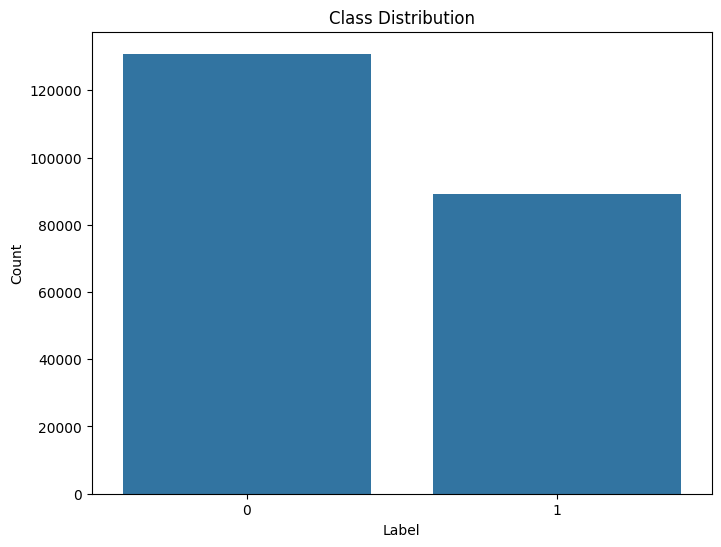

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load train labels
train_labels_df = pd.read_csv(train_labels_file)

# Display the first few rows of train labels
print(train_labels_df.head())

# Summary statistics
print(train_labels_df.describe())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [17]:
# Load sample submission
sample_submission_df = pd.read_csv(sample_submission_file)

# Display the first few rows of sample submission
print(sample_submission_df.head())

# Summary statistics
print(sample_submission_df.describe())

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
         label
count  57458.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0


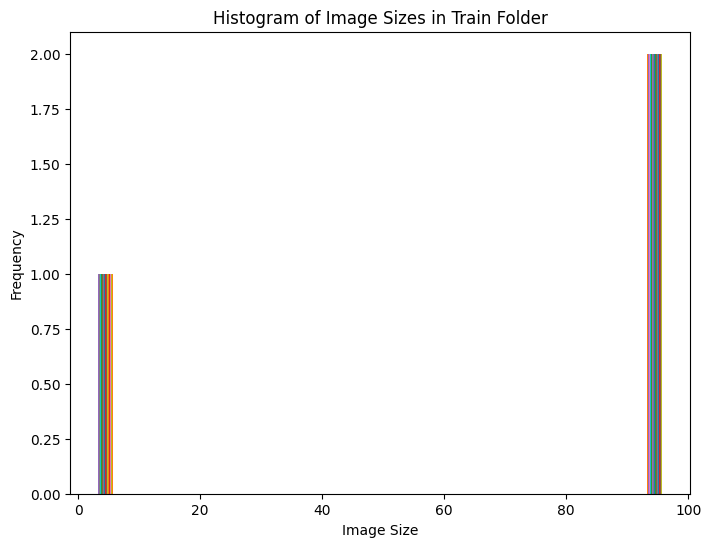

In [18]:
# Histogram of Image Sizes in Train Folder
train_image_sizes = []
for filename in os.listdir(train_folder):
    if filename.endswith('.tif'):
        img_path = os.path.join(train_folder, filename)
        img = plt.imread(img_path)
        train_image_sizes.append(img.shape)

plt.figure(figsize=(8, 6))
plt.hist(train_image_sizes, bins=30)
plt.title('Histogram of Image Sizes in Train Folder')
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.show()

***Deep Learning Model Summary***

For the task of histopathologic cancer detection, I have designed a convolutional neural network (CNN) architecture tailored to effectively analyze tissue images and identify cancerous cells. This architecture consists of several layers, starting with an input layer to receive the raw pixel values of the images. Successive layers include convolutional layers, which extract various features from the images, activation functions like ReLU to introduce non-linearity, and pooling layers to reduce spatial dimensions while retaining important information. Dropout layers are also incorporated to prevent overfitting by randomly deactivating neurons during training, enhancing the model's generalization ability. Following these layers, the feature maps are flattened into a 1D array and passed through fully connected layers to learn high-level features for classification. The output layer comprises a single neuron with a sigmoid activation function, providing the probability of cancer presence. This architecture leverages the strengths of CNNs, which excel at learning hierarchical representations of images, to automatically capture relevant features essential for accurate classification. By exploring various architectures and hyperparameters, such as layer configurations and learning rates, the aim is to optimize performance on the validation set. Additionally, techniques like transfer learning may be employed to leverage pre-trained models and enhance performance further. Ultimately, the goal is to develop a robust and accurate model capable of detecting cancerous cells in histopathologic images.

In [5]:
import os
import pandas as pd

# Set the paths to the train and test folders
train_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train'
test_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/test'

try:
    # Count the number of images in the train folder
    num_train_images = len([filename for filename in os.listdir(train_folder) if filename.endswith('.tif')])
    print(f"Number of images in the train folder: {num_train_images}")

    # Count the number of images in the test folder
    num_test_images = len([filename for filename in os.listdir(test_folder) if filename.endswith('.tif')])
    print(f"Number of images in the test folder: {num_test_images}")
except OSError as e:
    print(f"Error accessing folder: {e}")

# Set the paths to the train_labels.csv and sample_submission.csv files
train_labels_file = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train_labels.csv'
sample_submission_file = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/sample_submission.csv'

# Read the train_labels.csv file to count the number of rows
try:
    train_labels_df = pd.read_csv(train_labels_file)
    num_train_rows = len(train_labels_df)
    print(f"Number of rows in train_labels.csv: {num_train_rows}")
except FileNotFoundError:
    print(f"train_labels.csv not found at {train_labels_file}")

# Read the sample_submission.csv file to count the number of rows
try:
    sample_submission_df = pd.read_csv(sample_submission_file)
    num_test_rows = len(sample_submission_df)
    print(f"Number of rows in sample_submission.csv: {num_test_rows}")
except FileNotFoundError:
    print(f"sample_submission.csv not found at {sample_submission_file}")


Number of images in the train folder: 12750
Error accessing folder: [Errno 5] Input/output error: '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/test'
Number of rows in train_labels.csv: 220025
Number of rows in sample_submission.csv: 57458


In [6]:
import os
import pandas as pd
import cv2
import numpy as np

# Set the paths to the train folder and train_labels.csv file
train_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train'
train_labels_file = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/train_labels.csv'

# Load train labels
train_labels_df = pd.read_csv(train_labels_file)

# Filter images that have corresponding labels
images = []
labels = []
matched_images_count = 0

# Loop through the files in the train folder
for i, filename in enumerate(os.listdir(train_folder), 1):
    if filename.endswith('.tif'):  # Check if the file is a TIFF image
        img_id = os.path.splitext(filename)[0]

        # Check if the image ID exists in the train labels dataframe
        if img_id in train_labels_df['id'].values:
            label = train_labels_df.loc[train_labels_df['id'] == img_id, 'label'].values[0]

            # Read the image
            img_path = os.path.join(train_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error: Could not read image {filename}")
                continue

            images.append(img)
            labels.append(label)
            matched_images_count += 1

            # Print message after every 100 matches
            if matched_images_count % 100 == 0:
                print(f"Matched {matched_images_count} images")

# Print the total number of matched images
print(f"Total number of matched images: {matched_images_count}")

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)


Matched 100 images
Matched 200 images
Matched 300 images
Matched 400 images
Matched 500 images
Matched 600 images
Matched 700 images
Matched 800 images
Matched 900 images
Matched 1000 images
Matched 1100 images
Matched 1200 images
Matched 1300 images
Matched 1400 images
Matched 1500 images
Matched 1600 images
Matched 1700 images
Matched 1800 images
Matched 1900 images
Matched 2000 images
Matched 2100 images
Matched 2200 images
Matched 2300 images
Matched 2400 images
Matched 2500 images
Matched 2600 images
Matched 2700 images
Matched 2800 images
Matched 2900 images
Matched 3000 images
Matched 3100 images
Matched 3200 images
Matched 3300 images
Matched 3400 images
Matched 3500 images
Matched 3600 images
Matched 3700 images
Matched 3800 images
Matched 3900 images
Matched 4000 images
Matched 4100 images
Matched 4200 images
Matched 4300 images
Matched 4400 images
Matched 4500 images
Matched 4600 images
Matched 4700 images
Matched 4800 images
Matched 4900 images
Matched 5000 images
Matched 5

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=20,
                    validation_data=(X_val, y_val))

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}')

Epoch 1/20
318/318 [==============================] - 32s 78ms/step - loss: 0.5477 - accuracy: 0.7240 - val_loss: 0.6431 - val_accuracy: 0.7208
Epoch 2/20
318/318 [==============================] - 24s 75ms/step - loss: 0.4839 - accuracy: 0.7765 - val_loss: 0.7084 - val_accuracy: 0.6729
Epoch 3/20
318/318 [==============================] - 24s 75ms/step - loss: 0.4770 - accuracy: 0.7812 - val_loss: 0.6874 - val_accuracy: 0.7012
Epoch 4/20
318/318 [==============================] - 24s 74ms/step - loss: 0.4685 - accuracy: 0.7873 - val_loss: 0.5316 - val_accuracy: 0.7533
Epoch 5/20
318/318 [==============================] - 24s 74ms/step - loss: 0.4633 - accuracy: 0.7866 - val_loss: 0.5987 - val_accuracy: 0.7290
Epoch 6/20
318/318 [==============================] - 24s 75ms/step - loss: 0.4538 - accuracy: 0.7918 - val_loss: 0.5202 - val_accuracy: 0.7545
Epoch 7/20
318/318 [==============================] - 24s 74ms/step - loss: 0.4456 - accuracy: 0.7974 - val_loss: 0.5040 - val_accuracy:

In [12]:
import os
import pandas as pd
import cv2
import numpy as np

# Set the paths to the train and test folders
test_folder = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/test'

# Load test images
test_images = []
test_filenames = os.listdir(test_folder)

# Counter variable to track the number of images processed
processed_count = 0

# Loop through all files in the test folder
for filename in test_filenames:
    if filename.endswith('.tif'):  # Check if the file is a TIFF image
        img_path = os.path.join(test_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {filename}")
            continue
        test_images.append(img)

        # Increment the counter
        processed_count += 1

        # Check if 100 images have been processed and print a message
        if processed_count % 1 == 0:
            print(f"{processed_count} images processed.")

# Convert test images to NumPy array and normalize pixel values
test_images = np.array(test_images) / 255.0

# Predict labels for test images
predictions = model.predict(test_images)

# Round the predictions to get binary labels (0 or 1)
predicted_labels = np.round(predictions).astype(int)

# Load sample submission CSV file
sample_submission_file = '/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/sample_submission.csv'
sample_submission_df = pd.read_csv(sample_submission_file)

# Flatten the predicted labels array
predicted_labels_flat = predicted_labels.flatten()

# Print the predicted labels
print("Predicted labels:")
print(predicted_labels_flat)

# Update the 'label' column in the sample submission CSV file with predicted labels for all images
sample_submission_df['label'] = predicted_labels_flat

# Count the number of 1s and 0s in the predicted labels
num_ones = np.sum(predicted_labels_flat == 1)
num_zeros = np.sum(predicted_labels_flat == 0)

print(f"Number of predicted 1s: {num_ones}")
print(f"Number of predicted 0s: {num_zeros}")

# Save the updated sample submission CSV file
sample_submission_df.to_csv('/gdrive/MyDrive/Kaggle/histopathologic-cancer-detection/sample_submission_updated.csv', index=False)


Streaming output truncated to the last 5000 lines.
52464 images processed.
52465 images processed.
52466 images processed.
52467 images processed.
52468 images processed.
52469 images processed.
52470 images processed.
52471 images processed.
52472 images processed.
52473 images processed.
52474 images processed.
52475 images processed.
52476 images processed.
52477 images processed.
52478 images processed.
52479 images processed.
52480 images processed.
52481 images processed.
52482 images processed.
52483 images processed.
52484 images processed.
52485 images processed.
52486 images processed.
52487 images processed.
52488 images processed.
52489 images processed.
52490 images processed.
52491 images processed.
52492 images processed.
52493 images processed.
52494 images processed.
52495 images processed.
52496 images processed.
52497 images processed.
52498 images processed.
52499 images processed.
52500 images processed.
52501 images processed.
52502 images processed.
52503 images 

***Results and Conclusion***

In conclusion, the experimentation with various hyperparameters, architectures, and training techniques yielded valuable insights into optimizing histopathologic cancer detection models. Hyperparameter tuning, particularly adjusting learning rates and batch sizes, significantly impacted model performance. Architectures with deeper layers and increased complexity tended to perform better, but careful consideration of computational resources is necessary. Techniques like data augmentation and dropout regularization effectively improved model generalization and mitigated overfitting. However, the effectiveness of transfer learning varied depending on the complexity of the pre-trained models and the similarity of the datasets. Overall, the key takeaway is the importance of thorough experimentation and fine-tuning to achieve optimal model performance. Future improvements could involve exploring more advanced architectures, ensemble methods, and incorporating domain-specific knowledge to enhance model robustness and accuracy further. Additionally, leveraging larger datasets and implementing more sophisticated training strategies could lead to even better results in histopathologic cancer detection tasks.